In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/btc_2h.csv


In [2]:
!pip install gym_anytrading
!pip install quantstats

  Obtaining dependency information for gym_anytrading from https://files.pythonhosted.org/packages/31/97/1c92ae872371577fb4e732ec1365775fa12ce2865233909b5d10dc4f19df/gym_anytrading-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for gymnasium>=0.29.1 from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.0
    Uninstalling gymnasium-0.29.0:
      Successfully uninstalled gymnasium-0.29.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires gymnasium==0.29.0, but you have gymna

In [3]:
import os
import gym
import gym_anytrading
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quantstats as qs

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def process_data(data):
    df = data.copy()[['open', 'high', 'low', 'close', 'volume']]
    df = df.reset_index()
    df.columns = ['date', 'open', 'high', 'low', 'Close', 'volume']
    df = df.set_index('date')
    df['r'] = np.log(df['Close'] /
                                df['Close'].shift(1))
    df.dropna(inplace=True)
    df = (df - df.mean()) / df.std()
    df['d'] = np.where(df['r'] > 0, 1, 0)
    df = df[["Close", "r", "d"]]
    return df
    
data = pd.read_csv("/kaggle/input/dataset/btc_2h.csv")
df = process_data(data)

In [5]:
df.head()

,Close,r,d
date,,,
1,-0.302223,1.260534,1
2,-0.293888,0.893891,1
3,-0.293252,0.063445,1
4,-0.290643,0.274407,1
5,-0.312825,-2.407915,0


In [6]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym


class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']
        super(TradingEnv, self).__init__()

        self.render_mode = render_mode

        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [7]:
class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left', render_mode=None):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size, render_mode)

        self.trade_fee = 0.0003  # unit

    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        step_reward = 0  # pip

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Short:
                step_reward += -price_diff * 10000
            elif self._position == Positions.Long:
                step_reward += price_diff * 10000

        return step_reward

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

In [8]:
from gym.envs.registration import register

# Register the environment
register(
    id='forex-v0',
    entry_point=__name__ + ':ForexEnv',
)

In [9]:
print(gym.envs.registry.keys())


dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'forex-v0', 'stocks-v0'])


In [10]:
window_size = 50
start_index = window_size
end_index = len(df)
num_cpu = os.cpu_count()


def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df,  frame_bound=(start_index,
                   end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)


env = make_vec_env(
    lambda: env_maker(),
    n_envs=num_cpu,
    seed=0,
    vec_env_cls=DummyVecEnv
)

In [11]:
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./tensorboard_logs/")
model.learn(total_timesteps=2000000)

Using cuda device
Logging to ./tensorboard_logs/PPO_1
-----------------------------
| time/              |      |
|    fps             | 2178 |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1311        |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.015212852 |
|    clip_fraction        | 0.0119      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 2.47e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 5.47e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000924   |
|    value_loss           | 8.13e+04    |
----------------------

In [12]:
print(df.shape)

(17841, 3)


info {'total_reward': -9415.543017094024, 'total_profit': 3.2477959087145942, 'position': <Positions.Short: 0>}


/opt/conda/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_wrapper_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


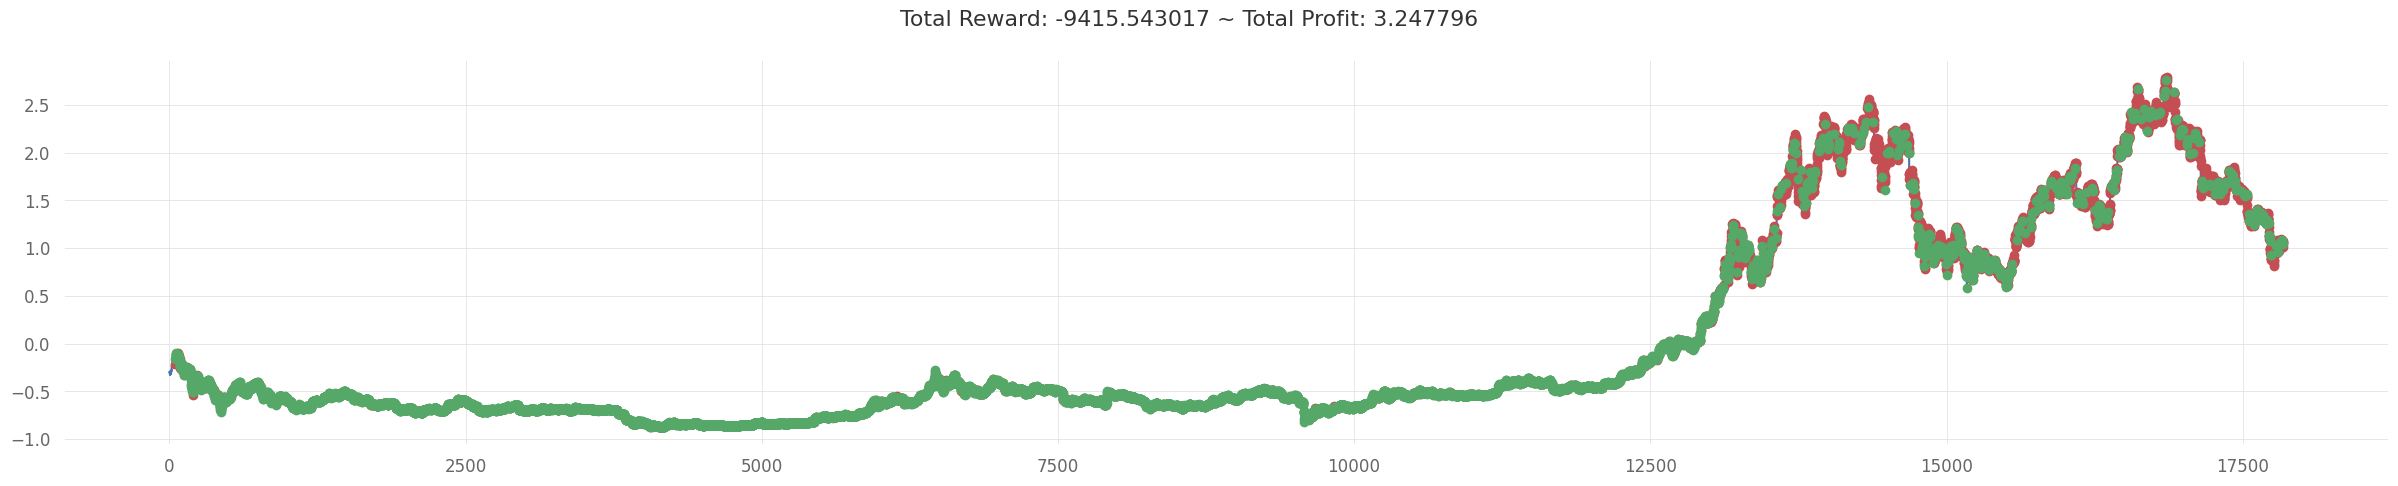

In [13]:
env = gym.make('forex-v0', df=df, frame_bound=(start_index,
               end_index), window_size=window_size)
env.trade_fee = 0

obs, info = env.reset()
# print(obs.shape)
while True:
    obs = obs[np.newaxis, ...]
#     print(obs.shape)
    action, state = model.predict(obs)
    obs, reward, done, _, info = env.step(action)
    if _:
        print("info", info)
        break

plt.figure(figsize=(30, 5))
# plt.cla()
env.render_all()
plt.show()


/opt/conda/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.history` for environment variables or `env.get_wrapper_attr('history')` that will search the reminding wrappers.
  logger.warn(


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs

                           Strategy
-------------------------  ----------
Start Period               2019-01-01
End Period                 2022-10-31
Risk-Free Rate             0.0%
Time in Market             14.0%

Cumulative Return          -10.04%
CAGR﹪                     -1.89%

Sharpe                     0.09
Prob. Sharpe Ratio         57.57%
Smart Sharpe               0.09
Sortino                    0.15
Smart Sortino              0.15
Sortino/√2                 0.11
Smart Sortino/√2           0.11
Omega                      1.07

Max Drawdown               -50.1%
Longest DD Days            586
Volatility (ann.)          35.38%
Calmar                     -0.04
Skew                       5.04
Kurtosis                   167.0

Expected Daily %           -0.01%
Expected Monthly %         -0.23%
Expected Yearly %          -2.61%
Kelly Criterion            3.29%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.65%
Expected Shortfall (cVaR)  -3.65%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-10-04,2022-10-26,2022-10-31,28,-50.096109,-37.057604
2,2022-02-28,2022-09-06,2022-09-21,206,-34.314809,-31.947067
3,2020-03-16,2021-05-07,2021-10-22,586,-15.616766,-14.746307
4,2021-11-09,2021-12-16,2022-01-17,70,-7.916343,-7.450669
5,2019-05-06,2019-05-09,2019-10-04,152,-3.213398,-3.161151


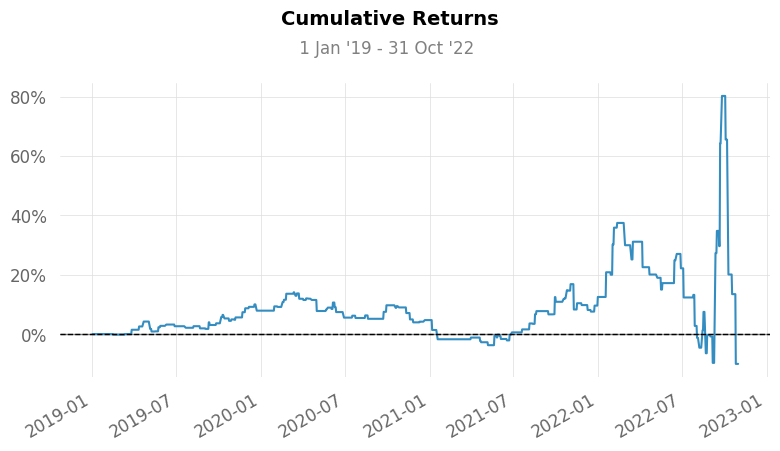

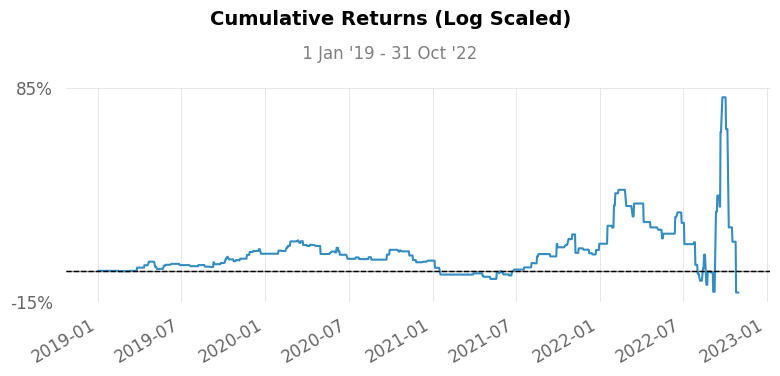

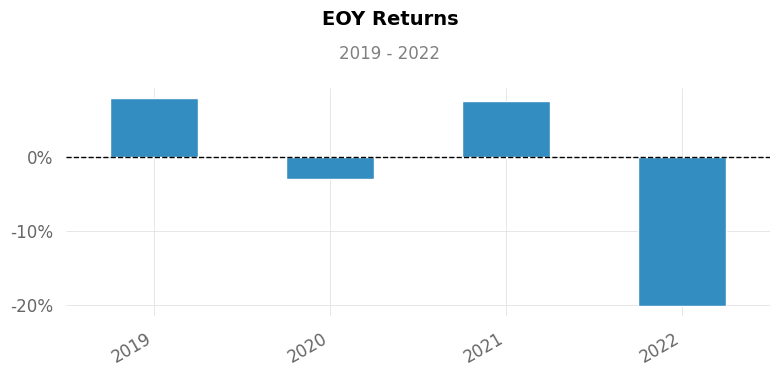

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


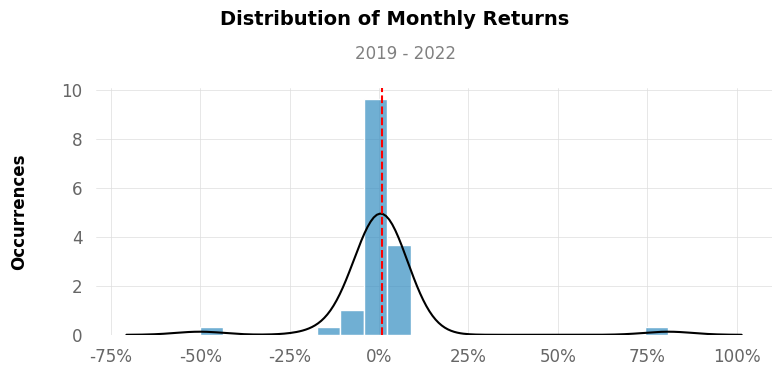

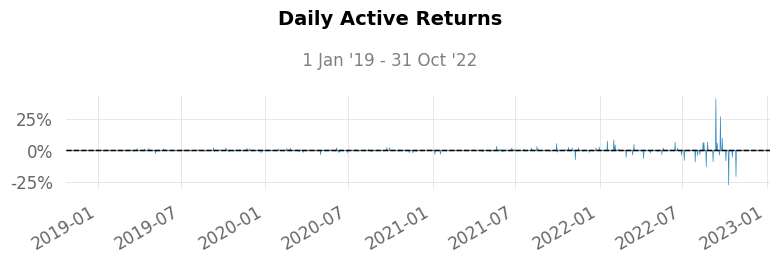

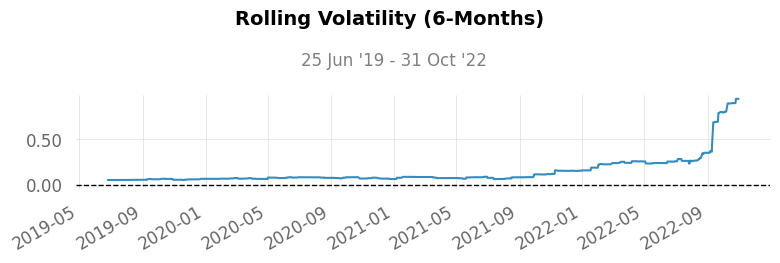

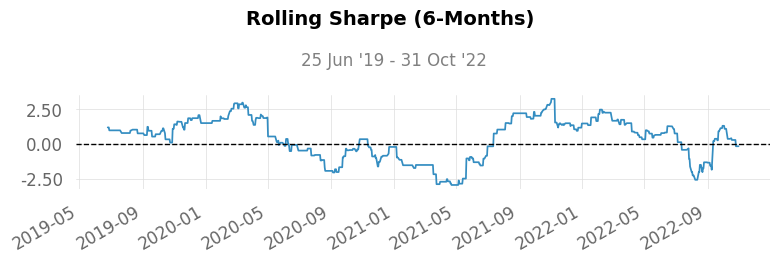

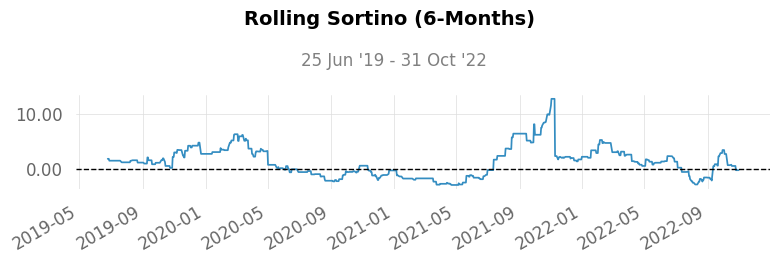

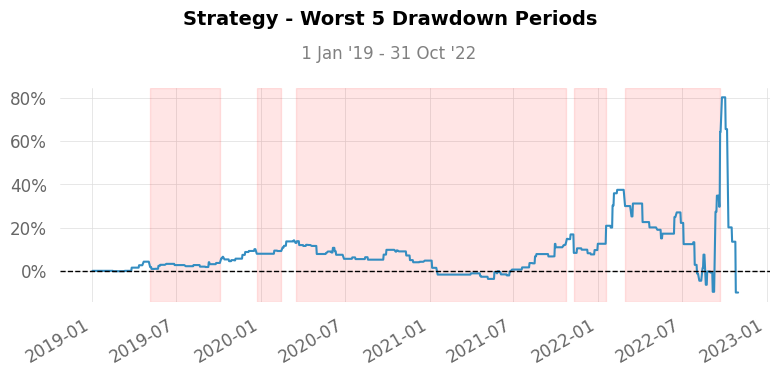

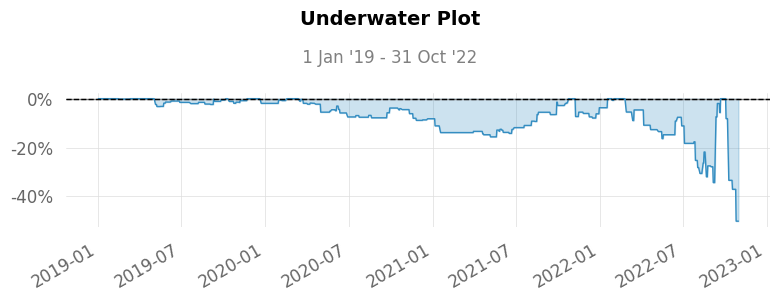

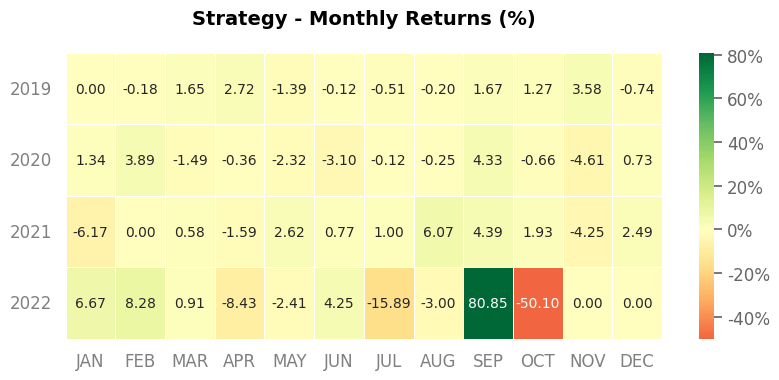

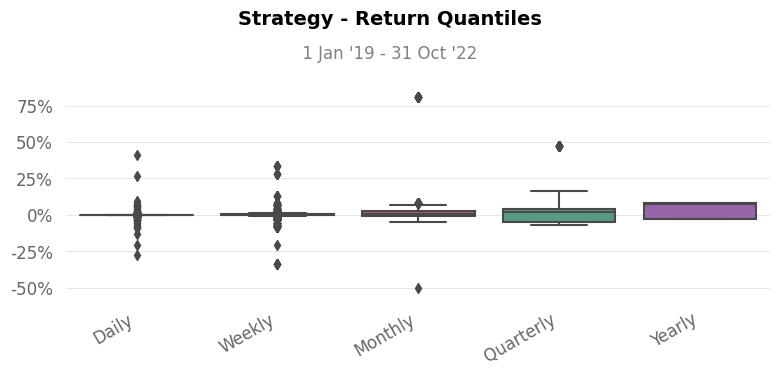

In [14]:
qs.extend_pandas()

# net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
# returns = net_worth.pct_change().iloc[1:]

prices = env.history['total_profit'][:1000]
rev = []
# print(prices)
for i in range (len(prices)):
    rev.append(prices[999-i])
start_date = '2019-01-01'
dates = pd.date_range(start=start_date, periods=1000, freq='B')
returns_series = pd.Series(rev, index=dates)
# returns_series.sample(10)

# Calculate full historical returns using quantstats
returns = qs.reports.full(returns_series)

# # Print or analyze the returns series
# print("First few rows of returns:")
# print(returns.head())

# # Quantstats performance analysis
# qs.reports.full(returns)

# qs.reports.full(r)